# Import supporting package

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

# Import supporting package

In [2]:
import xarray as xr
import numpy as np

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FitAnalyser import NewFitModel
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [3]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

C:\Users\data\AppData\Roaming\Python\Python39\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59239 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:59240' processes=6 threads=60, memory=55.88 GiB>

## Set global path for experiment

In [4]:
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/03/0043/*.h5"
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/2023-04-18_0003_Evaporative_Cooling_000.h5"

# filepath = "//DyLabNAS/Data/Repetition_scan/2023/04/21/0002/*.h5"

# filepath = r"./testData/0002/*.h5"

# filepath = r"./testData/0002/2023-04-21_0002_Evaporative_Cooling_0.h5"

# filepath = r'd:/Jianshun Gao/Simulations/analyseScripts/testData/0002/2023-04-21_0002_Evaporative_Cooling_0.h5'

# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/*.h5"

# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/04/0000/*.h5"

filepath = './result_from_experiment/2023-04-24/0013/2023-04-24_0013_Evaporative_Cooling_08.h5'

In [5]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_3",
}


In [6]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/05/23'# get_date()

# An example for one experimental run

## Load the data

In [7]:
shotNum = "0069"
filePath = folderPath + "/" + shotNum + "/*.h5"
# filePath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/12/0065/*.h5"
filePath = './result_from_experiment/2023-04-24/0013/2023-04-24_0013_Evaporative_Cooling_08.h5'

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0] # range(len(groupList))
}

dataSet = dataSetDict["camera_1"]
dataSet = swap_xy(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

f:\Jianshun\analyseScript\DataContainer\ReadData.py:178: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not key in datesetOfGlobal.scanAxis


<xarray.Dataset>
Dimensions:     (y: 1200, x: 1920)
Dimensions without coordinates: y, x
Data variables:
    atoms       (y, x) uint16 dask.array<chunksize=(1200, 1920), meta=np.ndarray>
    background  (y, x) uint16 dask.array<chunksize=(1200, 1920), meta=np.ndarray>
    dark        (y, x) uint16 dask.array<chunksize=(1200, 1920), meta=np.ndarray>
    shotNum     int64 0
    OD          (y, x) float64 dask.array<chunksize=(1200, 1920), meta=np.ndarray>
Attributes: (12/96)
    TOF_free:                          0.02
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    y_offset:                          0
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    scanAxis:                          []
    scanAxisLength:                    []

## Calculate an plot OD images

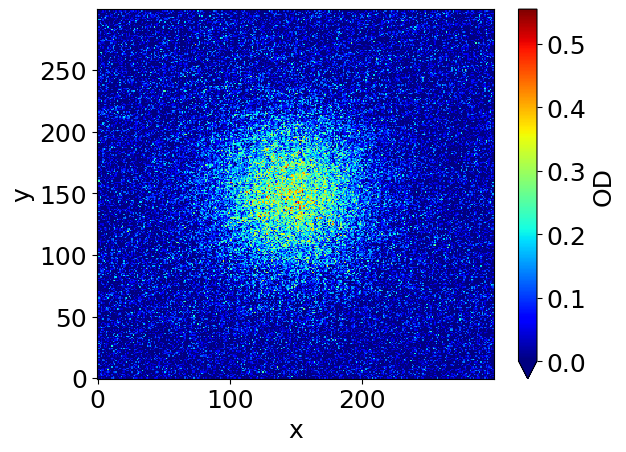

In [8]:
# imageAnalyser.center = (960, 1040)
# imageAnalyser.span = (100, 100)
# imageAnalyser.fraction = (0.1, 0.1)

imageAnalyser.center = (960, 875)
imageAnalyser.span = (300, 300)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

## Do a 2D two-peak gaussian fit to the OD images

### Do the fit

In [9]:
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, polylog2_2d

fitModel = DensityProfileBEC2dModel()
# fitModel = ThomasFermi2dModel()

fitAnalyser = FitAnalyser(fitModel, fitDim=2)

# fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)

# dataSet_cropOD = dataSet_cropOD.chunk((1,1,100,100))

params = fitAnalyser.guess(dataSet_cropOD, guess_kwargs=dict(pureBECThreshold=0.3), dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params).load()

f:\Jianshun\analyseScript\Analyser\FitAnalyser.py:84: RuntimeWarning: invalid value encountered in power
  res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)**(3 / 2)


In [10]:
params.compute().item()

Parameters([('BEC_amplitude', <Parameter 'BEC_amplitude', value=0, bounds=[0:inf]>), ('thermal_amplitude', <Parameter 'thermal_amplitude', value=3073.528205527723, bounds=[0:inf]>), ('BEC_centerx', <Parameter 'BEC_centerx', value=146.94301032591366, bounds=[-inf:inf]>), ('BEC_centery', <Parameter 'BEC_centery', value=147.47224593536436, bounds=[-inf:inf]>), ('thermal_centerx', <Parameter 'thermal_centerx', value=120.55703835420424, bounds=[-inf:inf]>), ('thermal_centery', <Parameter 'thermal_centery', value=179.3646237177809, bounds=[-inf:inf]>), ('BEC_sigmax', <Parameter 'BEC_sigmax', value=17.155488681677085, bounds=[0:inf]>), ('BEC_sigmay', <Parameter 'BEC_sigmay', value=18.315601451967396, bounds=[0:inf]>), ('thermal_sigmax', <Parameter 'thermal_sigmax', value=71.84654400127174, bounds=[0:inf]>), ('thermal_sigmay', <Parameter 'thermal_sigmay', value=86.21585280152608, bounds=[-inf:inf], expr='thermalAspectRatio * thermal_sigmax'>), ('thermalAspectRatio', <Parameter 'thermalAspectRatio', value=1.2, bounds=[0.8:1.2]>), ('condensate_fraction', <Parameter 'condensate_fraction', value=0.0, bounds=[-inf:inf], expr='BEC_amplitude / (BEC_amplitude + thermal_amplitude)'>)])

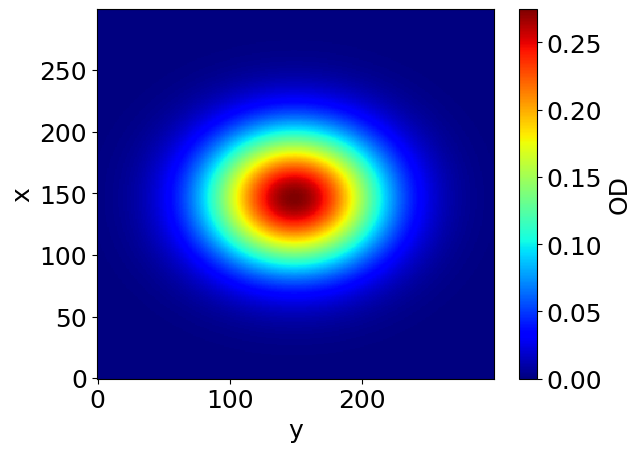

In [11]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(300), y=np.arange(300), dask="parallelized").load()

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])

In [12]:
fitModel2 = Polylog22dModel(prefix='thermal_')
fitAnalyser2 = FitAnalyser(fitModel2, fitDim=2)
fitCurve2 = fitAnalyser2.eval(fitResult, x=np.arange(100), y=np.arange(100), dask="parallelized").load()

fitModel3 = ThomasFermi2dModel(prefix='BEC_')
fitAnalyser3 = FitAnalyser(fitModel3, fitDim=2)
fitCurve3 = fitAnalyser3.eval(fitResult, x=np.arange(100), y=np.arange(100), dask="parallelized").load()

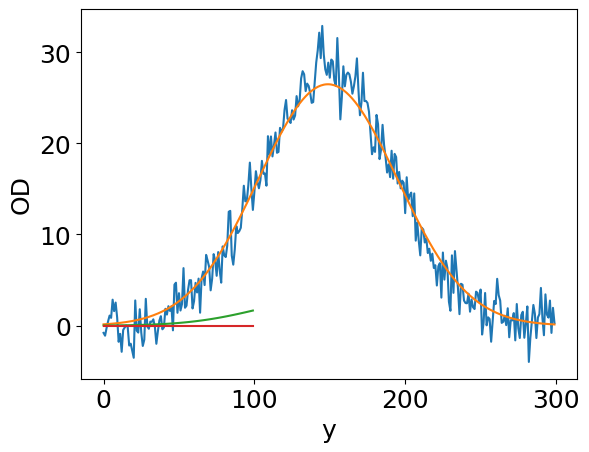

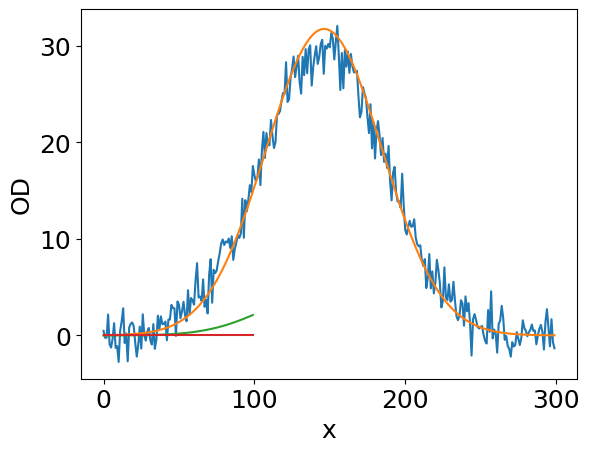

In [13]:
fig = plt.figure()
ax = fig.gca()

dataSet_cropOD.sum(dim='x').plot(ax=ax, col=scanAxis[0], row=scanAxis[1])
fitCurve.sum(dim='x').plot(ax=ax, col=scanAxis[0], row=scanAxis[1])
fitCurve2.sum(dim='x').plot(ax=ax, col=scanAxis[0], row=scanAxis[1])
fitCurve3.sum(dim='x').plot(ax=ax, col=scanAxis[0], row=scanAxis[1])

plt.show()

fig = plt.figure()
ax = fig.gca()

dataSet_cropOD.sum(dim='y').plot(ax=ax, col=scanAxis[0], row=scanAxis[1])
fitCurve.sum(dim='y').plot(ax=ax, col=scanAxis[0], row=scanAxis[1])
fitCurve2.sum(dim='y').plot(ax=ax, col=scanAxis[0], row=scanAxis[1])
fitCurve3.sum(dim='y').plot(ax=ax, col=scanAxis[0], row=scanAxis[1])

plt.show()

In [14]:
value = fitAnalyser.get_fit_full_result(fitResult)

C:\Users\data\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2246: RuntimeWarning: invalid value encountered in _get_fit_full_result_single (vectorized)
  outputs = ufunc(*inputs)


In [15]:
value

<xarray.Dataset>
Dimensions:              ()
Data variables:
    BEC_amplitude        object 0.0+/-nan
    thermal_amplitude    object 3066.9094836204504+/-nan
    BEC_centerx          object 146.94301032591366+/-nan
    BEC_centery          object 147.47224593536436+/-nan
    thermal_centerx      object 146.23870549779576+/-nan
    thermal_centery      object 148.7788885260284+/-nan
    BEC_sigmax           object 17.155488681677085+/-nan
    BEC_sigmay           object 18.315601451967396+/-nan
    thermal_sigmax       object 54.3744707945104+/-nan
    thermal_sigmay       object 65.24936495341248+/-nan
    thermalAspectRatio   object 1.2+/-nan
    condensate_fraction  object 0.0+/-nan

In [17]:
fitResult.to_netcdf("saved_on_disk.nc")

ValueError: unable to infer dtype on variable 'OD'; xarray cannot serialize arbitrary Python objects

# Get the Ncount

In [ ]:
Ncount = dataSet_crop.OD.sum(dim=(scanAxis[0], 'x', 'y'))

In [ ]:
Ncount.load()

fig = plt.figure()
ax = fig.gca()
Ncount.plot(ax=ax)

In [ ]:
fitAnalyser = FitAnalyser("Lorentzian With Offset")
params = fitAnalyser.guess(Ncount, x='runs', dask="parallelized", guess_kwargs=dict(negative=True))

In [ ]:
fitResult = fitAnalyser.fit(Ncount, params, x='runs', dask="parallelized")
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(40), dask="parallelized").load()

In [ ]:
fig = plt.figure()
ax = fig.gca()
plt.errorbar([1], [1], yerr=[1])

In [ ]:
fitCurve.plot.errorbar(yerr=fitCurve)

In [ ]:
np.ufunc(fitCurve)

# Read CSV

In [ ]:
# filePath = 'Z:/Dy_Lab/Data/Measurements/Experiments/DyBEC/BEC Stability Check/20230509-0007/*.csv'

# filePath = np.sort(glob.glob(filePath))

# read_csv_file(filePath, maxFileNum=5, csvEngine='pandas', csvKwargs=dict(header=[0,1], na_filter=False, index_col=0))
# read_csv_file(filePath, csvEngine='dask')

In [ ]:
filePath = 'Z:/Dy_Lab/Data/Measurements/Experiments/DyBEC/BEC Stability Check/20230509-0007/*.csv'

filePath = np.sort(glob.glob(filePath))

data = np.empty(filePath.shape,dtype=object)

i = 0
for fp in filePath:
    data_single = pd.read_csv(fp)
    data_single = xr.Dataset.from_dataframe(data_single)
    data_single = data_single.drop_isel(index=0)
    # data_single = data_single.expand_dims(dim='runs')
    data[i] = data_single
    i = i + 1

data = xr.concat(data, 'runs')

data = data.assign_coords(dict(index=data.Time.isel(runs=0).astype(float))).rename(dict(index='time')).astype(float)

In [ ]:
data

In [ ]:
arm2_mean = data['Channel A'].mean(dim='runs')
arm2_std = data['Channel A'].std(dim='runs')

In [ ]:
arm2_mean.plot.errorbar(yerr=arm2_std, fmt='ob')

In [ ]:
arm2_std.plot.errorbar(fmt='ob')

In [ ]:
data['Channel A'].sel(time=4.55, method='nearest').plot.errorbar(fmt='ob')

plt.ylim([0, 0.15])
plt.show()